In [1]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA
import statsmodels.api as sm
import scipy.fftpack as fft
import os
from sklearn.model_selection import train_test_split

## Filter

In [3]:
def filter_sig(record_name):
    # Load the ECG recording and associated metadata
    record = wfdb.rdrecord(record_name)

    # Extract the ECG signal from all channels
    ecg_signal = record.p_signal

    # Define the filter cut-off frequencies in Hz
    lowcut = 1.0
    highcut = 40.0

    # Define the filter order
    order = 4

    # Compute the Nyquist frequency
    nyq = 0.5 * record.fs

    # Compute the filter cut-off frequencies in normalized units
    low = lowcut / nyq
    high = highcut / nyq

    # Compute the filter coefficients using a Butterworth filter for each channel
    filtered_signal = np.zeros_like(ecg_signal)
    for i in range(ecg_signal.shape[1]):
        b, a = butter(order, [low, high], btype='band')
        filtered_signal[:, i] = filtfilt(b, a, ecg_signal[:, i])
    return filtered_signal

## Segment signal into slices

In [4]:
def segment_sig(signal):
    segment_size = 1000

    # Calculate the number of segments
    num_segments = signal.shape[0] // segment_size

    # Create an empty numpy array to store the segments
    segments = np.empty((num_segments, segment_size, signal.shape[1]))

    # Split the signal into segments
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size
        segments[i] = signal[start_idx:end_idx]
    return segments

## Apply AC-DCT to signal

In [5]:
def AC_DCT(signal):   
    ac_dct_signal = np.zeros((len(signal),100,15))  # Array to store AC DCT coefficients
    # Iterate over each segment of the signal
    for i in range(signal.shape[0]):
        segment = signal[i]

        # Iterate over each channel in the segment
        for j in range(segment.shape[1]):
            channel = segment[:100, j]

            # Auto-Correlation
            ac = sm.tsa.acf(channel, nlags=1000)

            # Discrete Cosine Transform
            dct = fft.dct(ac, type=2)

            # Store AC DCT coefficients in the array
            ac_dct_signal[i, :100, j] = dct

    # Print the shape of the AC DCT signal
    return ac_dct_signal

## PCA

In [6]:
def PCA_sig(X_train,X_test):
    num_components = 20
    pca_signal = np.zeros((38,num_components))

    pca = PCA(n_components=num_components)
    pca =pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    # Print explained variance ratio for each principal component
    print('Explained variance ratio for hearbeat {}: {}'.format(i+1, pca.explained_variance_ratio_))
    print(sum(pca.explained_variance_ratio_))
    return X_train,X_test

## Prepare data and add the result to the dataframe

In [7]:
def prepare_data(patient_no,ac_dct_signal):
    sig = np.zeros((len(ac_dct_signal),(100*15)+1))
    for i in range(len(ac_dct_signal)): 
        x= np.append(ac_dct_signal[i].flatten(), patient_no)
        sig[i] = x
    sig.shape
    X=sig[:,:1500]
    y=sig[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [8]:
def add_to_df(X_train,X_test,y_train,y_test,df):
    # Create dataframes for each array
    train_df = pd.DataFrame(X_train, columns=['Feature_{}'.format(i) for i in range(X_train.shape[1])])
    train_df['Target'] = y_train

    test_df = pd.DataFrame(X_test, columns=['Feature_{}'.format(i) for i in range(X_test.shape[1])])
    test_df['Target'] = y_test

    # Concatenate the train and test dataframes
    combined_df = pd.concat([df,train_df, test_df], axis=0).reset_index(drop=True)

    # Print the combined dataframe
    return combined_df

## Main


In [42]:
patients = ['patient174','patient174','patient174','patient180','patient180','patient180','patient185','patient214']
records=   ['s0300lre','s0324lre','s0325lre','s0475_re','s0374lre','s0476_re','s0336lre','s0436_re']
# Define the patient and recording names
df = pd.DataFrame()
for i in range(len(patients)):
    record_name = f'{patients[i]}/{records[i]}'
    filtered_signal = filter_sig(record_name)
    signal=segment_sig(filtered_signal[300:])
    ac_dct_signal = AC_DCT(signal)
    patient_no = patients[i][7:]
    X_train, X_test, y_train, y_test = prepare_data(patient_no,ac_dct_signal)
    X_train,X_test = PCA_sig(X_train,X_test)
    df = add_to_df(X_train,X_test,y_train,y_test,df)
df

D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 1: [0.48747541 0.14336816 0.06697648 0.04673535 0.04055426 0.03704727
 0.02685251 0.02166799 0.01912801 0.01268997 0.0125418  0.0103437
 0.00848404 0.00716567 0.00624454 0.00571562 0.0052524  0.0043484
 0.00393968 0.00335303]
0.9698843053012373


D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 2: [0.43135783 0.1423616  0.06501051 0.05204245 0.04447743 0.03503406
 0.02875399 0.02390472 0.01914271 0.01816983 0.01456631 0.01359608
 0.01156846 0.01114445 0.01024037 0.00787067 0.00770334 0.00565005
 0.00517166 0.00460827]
0.9523747886521347


D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 3: [0.37052203 0.13629747 0.07547336 0.06264818 0.04698281 0.03701946
 0.03550527 0.0272817  0.02294109 0.01908295 0.01826084 0.01713075
 0.01386509 0.01309953 0.01159534 0.00903576 0.00824915 0.00663302
 0.00619827 0.00565382]
0.9434758889302359


D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 4: [0.31709908 0.17822692 0.07537606 0.05784528 0.04651667 0.03689804
 0.02862915 0.02602756 0.02175704 0.01952727 0.0181281  0.01586366
 0.01417338 0.0132369  0.01204655 0.01028865 0.01000017 0.00841419
 0.00800833 0.00719594]
0.9252589722478318


D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 5: [0.41884599 0.13067851 0.08614866 0.07034547 0.03512796 0.02732405
 0.02473352 0.0242809  0.01980519 0.01602678 0.01357877 0.01242699
 0.01118422 0.01061518 0.0099216  0.00888459 0.00777735 0.00757144
 0.00697233 0.0055269 ]
0.9477763985643406


D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 6: [0.23865098 0.14625812 0.10374835 0.05910828 0.05564305 0.03757873
 0.03409136 0.02840022 0.02466858 0.02300959 0.02256322 0.01879503
 0.01734538 0.01600162 0.01463912 0.01346184 0.01232348 0.01117133
 0.0099492  0.00964958]
0.8970570404114134


D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 7: [0.35425819 0.09445706 0.07067392 0.06529249 0.05204739 0.04000401
 0.02877796 0.02500528 0.02364657 0.02167676 0.01940971 0.0183693
 0.01587197 0.01576352 0.01424038 0.01242022 0.01104766 0.01062257
 0.00970221 0.00819824]
0.9114854084330187


D:\AI\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Explained variance ratio for hearbeat 8: [0.45432156 0.17796561 0.07498576 0.05272232 0.03569007 0.03004418
 0.02093836 0.01951908 0.01692584 0.01269828 0.01037428 0.00937753
 0.00871461 0.00762162 0.00720475 0.00663898 0.00615078 0.00536021
 0.00502052 0.00470059]
0.9669749284680998


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Target
0,0.563894,-27.651872,-4.104407,39.997896,0.946165,9.929643,1.731378,-27.739661,11.814051,-16.247570,...,-25.134839,-12.323980,-9.285431,5.085570,-1.259299,-1.164029,1.787597,-14.898986,-13.624128,174.0
1,-47.069081,4.777334,23.668899,-1.494526,4.079126,6.219525,13.454602,-3.111150,-4.269745,-4.589224,...,3.699144,0.396980,-1.095760,-2.313230,-3.217391,2.422398,3.191262,-1.876169,-2.181530,174.0
2,87.580064,68.957803,-24.483299,20.099587,-14.564748,13.782585,4.291053,19.333600,-14.647395,2.183234,...,-6.511897,6.073350,-0.601690,-1.873165,-9.463481,-0.456301,-1.467119,-8.727795,3.042135,174.0
3,-67.800301,-4.261082,6.755723,-7.386537,25.887966,-2.374427,4.453961,-3.503804,-7.116013,6.348078,...,-1.549549,-0.090490,-2.792017,-1.761825,-5.233319,-1.937788,1.344041,-1.611306,-2.219085,174.0
4,-31.314307,-33.503198,-3.069644,5.036652,-21.603841,-22.266481,-3.565972,21.526742,-1.067324,1.093526,...,-10.541135,-0.439779,-5.411566,6.123481,1.148077,-0.896215,2.075294,-0.016857,-4.695255,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,67.307329,-13.221738,-7.205212,10.445711,11.727959,5.460432,-3.525082,-3.259497,14.772050,-15.840398,...,7.219480,-0.848730,-5.460500,7.082941,-19.837681,-14.197246,7.195635,-5.240220,5.332609,214.0
923,57.966623,-59.497084,-52.562410,22.266610,0.415830,-10.601152,-16.635296,-9.969256,-0.284113,-1.413732,...,3.691426,2.142297,7.482301,-8.763694,-3.739898,-3.502192,0.082057,4.367725,1.692940,214.0
924,62.182329,5.647307,0.720979,-16.834323,12.546339,-30.983102,10.163477,-1.794559,-2.934602,-10.574182,...,-3.692291,-11.730156,-1.922167,3.431611,-0.346141,7.539929,10.140424,10.847029,11.535777,214.0
925,-55.958432,-24.009413,-22.241092,5.122739,-20.917866,14.323255,-6.000734,2.180075,5.499502,13.206226,...,2.999924,-1.800772,-1.635239,-5.086017,-6.095222,-2.294350,1.067242,3.450276,6.593221,214.0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1],df['Target'], test_size=0.2, random_state=42,shuffle=True)

In [44]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC() # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       174.0       0.59      0.47      0.53        76
       180.0       0.43      0.73      0.54        67
       185.0       0.80      0.17      0.29        23
       214.0       1.00      0.30      0.46        20

    accuracy                           0.51       186
   macro avg       0.70      0.42      0.45       186
weighted avg       0.60      0.51      0.49       186



In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have X_train, X_test, y_train, y_test as your feature and target variables

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       174.0       0.46      0.38      0.42        76
       180.0       0.40      0.49      0.44        67
       185.0       0.32      0.30      0.31        23
       214.0       0.37      0.35      0.36        20

    accuracy                           0.41       186
   macro avg       0.39      0.38      0.38       186
weighted avg       0.41      0.41      0.41       186



In [17]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.44086021505376344


## ICA

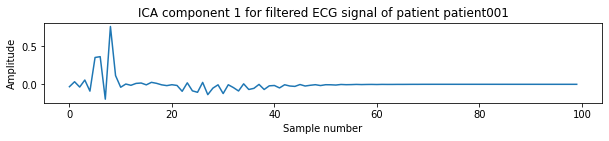

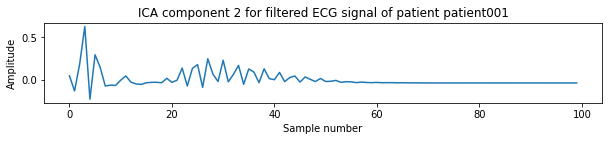

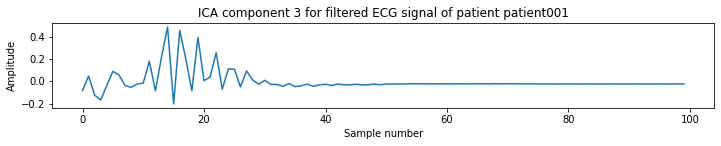

In [20]:
from sklearn.decomposition import FastICA

# Apply ICA with 3 components
ica = FastICA(n_components=3)
ica_signal = ica.fit_transform(dct_coeffs.T)

# Plot each independent component on a separate plot
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.subplot(3, 1, i+1)
    plt.plot(ica_signal[:, i])
    plt.title('ICA component {} for filtered ECG signal of patient {}'.format(i+1, patient))
    plt.xlabel('Sample number')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
